# Import data and data exploration

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from icecream import ic
%matplotlib inline

In [2]:
user_ratings_df = pd.read_csv(r'Data\user_ratings.csv',header=0, usecols=['userId','movieId','rating','title'])
user_ratings_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [3]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


# Non personalized Recommendation
## Most popular movies

In [19]:
# Get the counts of occurrences of each movie title
movie_popularity = user_ratings_df.title.value_counts()
print(movie_popularity.head().index)

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)'],
      dtype='object')


## Movie with highest average ratings
### Reviews only

In [25]:
user_ratings_df.groupby('title').agg({'rating':['mean']}).sort_values(by=('rating','mean'),ascending=False)

,rating
,mean
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
...,...
Don't Look Now (1973),0.5
Journey 2: The Mysterious Island (2012),0.5


In [30]:
# Find the mean of the ratings given to each title
average_rating_df = user_ratings_df[['title','rating']].groupby('title').mean()

# Order the entries by highest average rating to lowest
sorted_average_ratings = average_rating_df.sort_values(by='rating', ascending=False)

# Inspect the top movies
print(sorted_average_ratings.head())

                                     rating
title                                      
Gena the Crocodile (1969)               5.0
True Stories (1986)                     5.0
Cosmic Scrat-tastrophe (2015)           5.0
Love and Pigeons (1985)                 5.0
Red Sorghum (Hong gao liang) (1987)     5.0


### Combine popularity and reviews

In [42]:
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = user_ratings_df['title'].value_counts()
popular_movies = movie_popularity[movie_popularity >=50].index
# use popular movies list to filter the original DataFrame
popular_movies_rankings =  user_ratings_df[user_ratings_df.title.isin(popular_movies)]
popular_movies_average_ratings =popular_movies_rankings[['title','rating']].groupby('title').mean()
popular_movies_average_ratings.sort_values(by='rating',ascending = False).head()

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041


## Find all pair of movies
all permutations of pairs of movies that have been watched by the same person.

In [4]:
from itertools import permutations

In [12]:
def simplePair(X):
    '''
    return pairs of movies
    X: dataframe
    '''
    pairs = pd.DataFrame(list(permutations(X.values, 2)), columns=['movieA','movieB'])
    return pairs

In [24]:
# Apply the function to the title column and reset the index
movie_combinations = user_ratings_df.groupby('userId').title.apply(simplePair).reset_index(drop=True)


,movieA,movieB
0,Toy Story (1995),Grumpier Old Men (1995)
1,Toy Story (1995),Heat (1995)
2,Toy Story (1995),Seven (a.k.a. Se7en) (1995)
3,Toy Story (1995),"Usual Suspects, The (1995)"
4,Toy Story (1995),From Dusk Till Dawn (1996)


In [32]:
combinations_counts = movie_combinations.groupby(['movieA','movieB']).size()

combinations_counts_df = combinations_counts.to_frame(name='size').reset_index()

In [41]:
combinations_counts_df.sort_values(by='size', ascending = False,inplace =True)

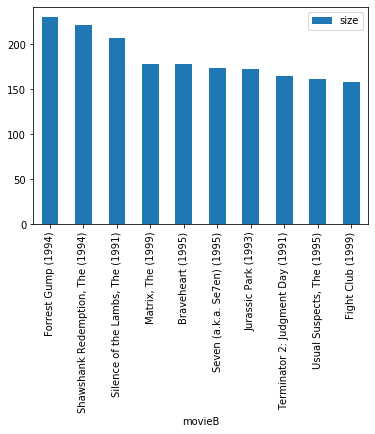

In [42]:
movie_Pulp=combinations_counts_df[combinations_counts_df.movieA == 'Pulp Fiction (1994)'].head(10)
movie_Pulp.plot.bar(x='movieB')

In [26]:
test=pd.DataFrame(list(permutations(range(3), 2) ), columns=['mov1', 'mov2'])
test.groupby(['mov1','mov2']).size()

mov1  mov2
0     1       1
      2       1
1     0       1
      2       1
2     0       1
      1       1
dtype: int64

In [35]:
combinations_counts_df.movieA.value_counts()


Forrest Gump (1994)                          9318
Matrix, The (1999)                           9071
Pulp Fiction (1994)                          8939
Star Wars: Episode IV - A New Hope (1977)    8906
Silence of the Lambs, The (1991)             8904
                                             ... 
Delirium (2014)                                20
One I Love, The (2014)                         20
Come See the Paradise (1990)                   20
Laggies (2014)                                 20
Circus (2000)                                  20
Name: movieA, Length: 9719, dtype: int64

In [39]:
movie_Pulp.head().sort

,movieA,movieB,size
18564136,Pulp Fiction (1994),'71 (2014),1
18564137,Pulp Fiction (1994),'Hellboy': The Seeds of Creation (2004),1
18564138,Pulp Fiction (1994),'Round Midnight (1986),1
18564139,Pulp Fiction (1994),'Tis the Season for Love (2015),1
18564140,Pulp Fiction (1994),"'burbs, The (1989)",11


## Content-based models(static)
Content-based models is suitable for new items recommendation(cold start).Imagine there is a large retailer that has a constantly changing product line, with new items being added every day.As the recommendations are based on the item attributes rather than user feedback, Content-based recommendations can be made on never-before-purchased products.

### Data preprocessing for genres column
one column contains all genres and seperate genre with |

In [4]:
# read columns and dedup
movie_genre_df=pd.read_csv(r'Data\user_ratings.csv',usecols=['title','genres'])
movie_genre_df.drop_duplicates(inplace=True, ignore_index= True)
print(movie_genre_df.head())
movie_genre_df.info()

                         title                                       genres
0             Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1      Grumpier Old Men (1995)                               Comedy|Romance
2                  Heat (1995)                        Action|Crime|Thriller
3  Seven (a.k.a. Se7en) (1995)                             Mystery|Thriller
4   Usual Suspects, The (1995)                       Crime|Mystery|Thriller
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9724 non-null   object
 1   genres  9724 non-null   object
dtypes: object(2)
memory usage: 152.1+ KB


In [5]:
# split the genres
geners=movie_genre_df['genres'].str.split('|',expand=True)
movie_genre_df=pd.concat([movie_genre_df,geners], axis=1)
# melt all columns together
movie_genre_df =pd.melt(movie_genre_df,id_vars=['title'], value_vars=[0,1,2,3,4,5,6,7,8,9])
# Drop records with null values
movie_genre_df.dropna(inplace=True)
movie_genre_df.drop('variable',axis=1, inplace= True)
movie_genre_df.drop_duplicates(inplace =True, ignore_index= True)
movie_genre_df.rename(columns={'value':'genre_list'}, inplace=True)
# test the data quality
print(movie_genre_df[movie_genre_df.title=='Toy Story (1995)'])
movie_genre_df.info()

                  title genre_list
0      Toy Story (1995)  Adventure
9721   Toy Story (1995)  Animation
16598  Toy Story (1995)   Children
20259  Toy Story (1995)     Comedy
21594  Toy Story (1995)    Fantasy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22036 entries, 0 to 22035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       22036 non-null  object
 1   genre_list  22036 non-null  object
dtypes: object(2)
memory usage: 344.4+ KB


In [40]:
# Create cross-tabulated DataFrame from name and genre_list columns
movie_cross_table = pd.crosstab(movie_genre_df['title'],movie_genre_df['genre_list'])
movie_cross_table[movie_cross_table.index.isin(['Toy Story (1995)','Yogi Bear (2010)'])]

genre_list,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Yogi Bear (2010),0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Comparing individual movies with Jaccard similarity
$J(A,B)= \dfrac{A \cap B}{A \cup B}$  

find most similar items of the item

In [45]:
from sklearn.metrics import jaccard_score
import numpy as np
# from scipy

#### Find similarity  between assigned pairs

In [57]:
# use jaccard_score to compare individual items. It needs to change to numpy array first
# Toy Story, and GoldenEye with SkyFall and compare the results.
# method1- get numpy array values
Toy = movie_cross_table.loc['Toy Story (1995)'].to_numpy()
GoldenEye = movie_cross_table.loc['GoldenEye (1995)'].to_numpy()
Skyfall = movie_cross_table.loc['Skyfall (2012)'].to_numpy()
# method2 - get numpy array values
Toy = movie_cross_table.loc['Toy Story (1995)'].values
GoldenEye = movie_cross_table.loc['GoldenEye (1995)'].values
Skyfall = movie_cross_table.loc['Skyfall (2012)'].values
ic(jaccard_score(Toy, GoldenEye))
ic(jaccard_score(Skyfall, GoldenEye))

ic| jaccard_score(Toy, GoldenEye): 0.14285714285714285
ic| jaccard_score(Skyfall, GoldenEye): 0.75


0.75

#### Comparing all  movies at once
When finding the similarities between the rows in a DataFrame, we could run through all pairs and calculate them individually, but it's more efficient to use the **pdist()** (pairwise distance) function from [scipy].

This can be reshaped into the desired rectangular shape using squareform() from the same library. Since you want similarity values as opposed to distances, you should subtract the values from 1.

In [59]:
from scipy.spatial.distance import pdist,squareform

In [ ]:
# Calculate all pairwise distances
jaccard_similarity =squareform(1- pdist(movie_cross_table.values, metric='jaccard'))

In [66]:
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')
jaccard_similarity = 1- squareform(jaccard_distances)



In [67]:
jaccard_similarity_df = pd.DataFrame(jaccard_similarity, columns=movie_cross_table.index, index=movie_cross_table.index)
jaccard_similarity_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.125,0.200000,0.333333,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.40,0.2,0.2,0.200000,0.400000,0.400000,0.400000,0.000000,0.000000
'Hellboy': The Seeds of Creation (2004),0.125000,1.000,0.000000,0.000000,0.000000,0.0,0.2,0.00,0.142857,0.285714,...,0.00,0.00,0.0,0.0,0.000000,0.142857,0.142857,0.142857,0.166667,0.166667
'Round Midnight (1986),0.200000,0.000,1.000000,0.200000,0.333333,0.0,0.0,0.50,0.250000,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
'Salem's Lot (2004),0.333333,0.000,0.200000,1.000000,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.75,0.5,0.5,0.200000,0.166667,0.166667,0.166667,0.000000,0.000000
'Til There Was You (1997),0.200000,0.000,0.333333,0.200000,1.000000,0.5,0.0,0.50,0.666667,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
# find movie name contains 'Yogi Bear'


for title in movie_cross_table.index.to_list():
    if re.match(r'Sky',title):
        print(title)


Sky Captain and the World of Tomorrow (2004)
Sky Crawlers, The (Sukai kurora) (2008)
Sky High (2003)
Sky High (2005)
Skyfall (2012)
Skyline (2010)


In [62]:
del jaccard_distances